In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import math
from copy import copy

#Preprocessing
from sklearn.preprocessing import StandardScaler, normalize, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

#Classification Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

import sklearn.metrics, sklearn.model_selection, sklearn.tree
import sklearn.neural_network


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


# Accuracy Metrics
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error ,r2_score


import plotly.graph_objs as go
import plotly.express as px

warnings.filterwarnings('ignore')

In [ ]:
#This is the dataset for the Death In Custody
#In order to let both users collaborate on the notebook we each need to apply our own path way for the file we are using for each ones machine.

#Dylan's Path
#deathCustody = pd.read_excel('/content/drive/MyDrive/Grad School/BDA 600/BDA 600 Project/DeathInCustody_2005-2021.xlsx')

#Layth's Path
deathCustody = pd.read_excel(open('/content/drive/MyDrive/BDA 600 - Project/DeathInCustody_2005-2021.xlsx', 'rb'),sheet_name='2005 - 2021')  #/content/drive/MyDrive/DeathInCustody_2005-2021.xlsx
#deathCustody = deathCustody.dropna() #Remove all NaN valued data points for better accuracy

deathCustody.isna().sum()

record_key_number                           0
reporting_agency                            0
agency_number                               0
agency_full_name                            0
county                                      0
latitude                                    0
longitude                                   0
race                                        2
gender                                      0
age                                         0
custody_status                              0
custody_offense                             0
date_of_death_yyyy                          0
date_of_death_mm                            0
date_of_death_dd                            0
custodial_responsibilty_at_time_of_death    0
location_where_cause_of_death_occurred      0
facility_death_occured                      1
manner_of_death                             0
means_of_death                              0
dtype: int64

# The Data

This dataset contains information on deaths related to police custody in California form 2005 and 2021. Each row represents a death and includes basic demographic information (age, race, gender) as well as some other features including: location, custodial responsibilty, custody status and the offence the criminal commited.

  The first step we took was to deal with the NA values. Thankfully this data set only had 3 NA values which represented a small portion of the 12k+ dataset.  Two rows didnt have the "race" value filled in so we classified this as "other". The other NA was for "facility_death_occured" so we matched that with the "custodial_responsibilty_at_time_of_death". These are the first two assumttions we made for this dataset.

  

In [ ]:
deathCustody.loc[deathCustody["race"].isna(),"race"] = "Other" # Changing NA values for race to other
deathCustody.loc[deathCustody["facility_death_occured"].isna(),"facility_death_occured"] = "CDC/CRC" # Chaning this value to CDC/CRC to fill the NA to match custodial_responsibilty_at_time_of_death
deathCustody.isna().sum()

record_key_number                           0
reporting_agency                            0
agency_number                               0
agency_full_name                            0
county                                      0
latitude                                    0
longitude                                   0
race                                        0
gender                                      0
age                                         0
custody_status                              0
custody_offense                             0
date_of_death_yyyy                          0
date_of_death_mm                            0
date_of_death_dd                            0
custodial_responsibilty_at_time_of_death    0
location_where_cause_of_death_occurred      0
facility_death_occured                      0
manner_of_death                             0
means_of_death                              0
dtype: int64

We also included a dataset that has some information of various statistis of each zipcode in California in the year 2021. We chose the columns that we surmised would be the most correlated with the death data. Our second assumption for this data is that these statistis were similar in 2021 as they were for the 6 previous years.  In order to merge the two datasets, we had to average the metrics of all the zipcodes in the same county to be able to match up to the deaths in custody. 
 
  

In [ ]:
# Loading it the 2021 California Environment Metric Data

calenvi_cols = ['Census Tract',
                'California County',
                'Total Population', 
                ' CES 4.0 Percentile',
                "Ozone Pctl",
                'Tox. Release', 
                'Solid Waste', 
                'Pollution Burden', 
                'Education', 
                'Linguistic Isolation', 
                'Poverty', 
                'Unemployment', 
                'Housing Burden']
#Layth's Path                
calEnvi = pd.read_excel('/content/drive/MyDrive/BDA 600 - Project/calenviroscreen40resultsdatadictionary_F_2021.xlsx',sheet_name='CES4.0FINAL_results',usecols=calenvi_cols)

#Dylan's Path
#calEnvi = pd.read_excel('/content/drive/MyDrive/Grad School/BDA 600/BDA 600 Project/calenviroscreen40resultsdatadictionary_F_2021.xlsx',sheet_name='CES4.0FINAL_results',usecols=calenvi_cols)
calEnvi.head(5)

,Census Tract,Total Population,California County,CES 4.0 Percentile,Ozone Pctl,Tox. Release,Solid Waste,Pollution Burden,Education,Linguistic Isolation,Poverty,Unemployment,Housing Burden
0,6001981900,58,Alameda,NaN,3.123833,466.708995,0.0,49.021836,NaN,NaN,NaN,NaN,NaN
1,6001982000,63,Alameda,NaN,3.123833,461.068003,0.0,50.018435,32.7,NaN,NaN,NaN,NaN
2,6001422600,1043,Alameda,NaN,3.123833,694.326325,0.0,35.368632,NaN,NaN,6.8,NaN,NaN
3,6009000504,457,Calaveras,NaN,68.176727,1.598387,6.2,17.128680,12.4,NaN,26.7,NaN,NaN
4,6019007901,3251,Fresno,NaN,63.609210,284.350006,0.0,24.578521,38.4,NaN,NaN,NaN,NaN


In [ ]:
# Loading it the 2021 California Demographic Metric Data
caldemo_cols = ['Census Tract',
                'Children < 10 years (%)', 
                'Pop 10-64 years (%)',
                'Elderly > 64 years (%)', 
                'Hispanic (%)',
                'White (%)',
                'African American (%)',
                'Native American (%)',
                'Asian American (%)',
                'Other/Multiple (%)']
#Layth's Path
calDemo = pd.read_excel('/content/drive/MyDrive/BDA 600 - Project/calenviroscreen40resultsdatadictionary_F_2021.xlsx',sheet_name='Demographic Profile', usecols = caldemo_cols)

#Dylan's Path
#calDemo = pd.read_excel('/content/drive/MyDrive/Grad School/BDA 600/BDA 600 Project/calenviroscreen40resultsdatadictionary_F_2021.xlsx',sheet_name='Demographic Profile', usecols = caldemo_cols)
calDemo.head(5)

,Census Tract,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%)
0,6001400100,7.82,66.12,26.06,3.78,74.26,3.43,0.00,12.53,5.99
1,6001400200,10.46,66.32,23.22,8.67,73.49,2.59,0.20,8.52,6.53
2,6001400300,11.42,73.04,15.54,6.95,67.99,9.09,0.00,12.14,3.84
3,6001400400,9.38,78.79,11.83,12.10,63.74,6.64,0.87,10.48,6.16
4,6001400500,9.12,81.96,8.92,9.46,45.44,21.39,0.00,11.34,12.37


Now that we have called in the two sheets of the 2021 California Enviromental Screening Dataset, we need to merge them together and average their values for each of the counties to get them into a format we can include them into our DeathCustody dataset that we will be using for our machine learning models later on. 

In [ ]:
calMetrics = calEnvi.merge(calDemo, on = 'Census Tract',how = "left")
calMetrics["California County"] = calMetrics["California County"].str.strip()

calMetrics_avgs = calMetrics.drop("Census Tract",axis = 1).groupby("California County").mean()
calMetrics_avgs.reset_index(inplace = True)
calMetrics_avgs.head()


,California County,Total Population,CES 4.0 Percentile,Ozone Pctl,Tox. Release,Solid Waste,Pollution Burden,Education,Linguistic Isolation,Poverty,...,Housing Burden,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%)
0,Alameda,4602.094444,41.310417,10.875786,466.776452,1.004444,37.323623,11.775706,8.729714,22.146369,...,15.929494,11.212917,74.897972,13.889083,21.662861,33.216806,11.321056,0.324889,28.557444,4.916722
1,Alpine,1039.000000,21.999496,62.526447,0.596264,8.000000,33.241256,8.800000,1.700000,38.900000,...,17.400000,9.050000,61.020000,29.930000,12.510000,53.030000,0.870000,30.220000,0.960000,2.410000
2,Amador,4269.888889,38.769821,66.977805,36.165427,8.788889,36.674443,9.344444,0.566667,25.188889,...,14.755556,7.792222,65.144444,27.062222,13.297778,78.566667,1.893333,0.625556,1.664444,3.958889
3,Butte,4427.784314,39.791166,61.685030,1.385422,2.635294,34.389987,11.103922,2.360417,39.931373,...,18.029412,11.556667,70.246667,18.196275,16.407451,71.456078,1.460000,0.831961,4.764510,5.079608
4,Calaveras,4551.400000,27.954278,71.717486,20.067040,11.475000,28.820814,9.450000,0.712500,28.240000,...,16.255556,8.508000,60.053000,31.439000,9.589000,84.191000,0.642000,0.448000,1.568000,3.564000


Below we are checking to see which of the counties are matching betweent the datasets.  There are 56 matching counties and each have two that the other doesnt have.  We can disregard the extra Counties from the calMetrics dataset since our Death Custody is the dataset we will be running our machine learning models on. The other two "counties" in the death dataset are 'In-State' and 'Out-of-State'.  These variables make up 153 rows so we decided to drop them since we dont have CalMetric information for these. After dropping these rows we are left with 12329 rows and 41 columns.  We will continue to do some more preprocessing on our data later on to further prepare it for our models.

In [ ]:
calmetric_set = set(calMetrics_avgs["California County"])
death_set = set(deathCustody["county"].str.strip())
print(len(calmetric_set))
print(len(death_set))
print(calmetric_set.symmetric_difference(death_set))

58
58
{'Alpine', 'Out-of-State', 'In-State', 'Plumas'}


In [ ]:
deathCustody2 = deathCustody[deathCustody["county"].isin(["Out-of-State",'In-State'])==False]
calMetrics_avgs2 = calMetrics_avgs[calMetrics_avgs["California County"].isin(['Alpine', 'Plumas'])==False]

merged_data = deathCustody2.merge(calMetrics_avgs2,left_on = "county", right_on = "California County")

merged_data['date_of_death'] = pd.to_datetime(merged_data['date_of_death_yyyy'].astype(str) + '-' +
                                     merged_data['date_of_death_mm'].astype(str) + '-' +
                                     merged_data['date_of_death_dd'].astype(str))

# Drop the original date columns
merged_data.drop(['date_of_death_yyyy', 'date_of_death_mm', 'date_of_death_dd'], axis=1, inplace=True)

# Convert the combined date column to datetime type
merged_data['date_of_death'] = pd.to_datetime(merged_data['date_of_death'])

# Verify the combined date column and its data type
merged_data.shape

(12329, 39)

##Manipulating the Dataset

Here we wanted in any case of combining this dataset of Death Custody to the other additional dataset with social and enviornmental levels of the population together to produce greater insight and analysis. To accomplish this a momentary function to insert the Longitude and Latitude into the Death Custody dataset and then save it to the CSV, to avoid the need to rerun the function every time.

There should be mention that we do comment out these code sections to allow us to run the rest of the code without running this section since it is essentailly a one time running process for manipulating the original datasheet.

In [ ]:
# list(deathCustody)

In [ ]:
# print("This is to originally check if these agencies had empty values that we wished to fill in for more geo analysis.")
# deathCustody[deathCustody['agency_full_name'] == "Orange Police Department"]

In [ ]:
# print("Here we wish to check all the unique values of this data point as it is our basis to find the latitude and longitude of each agency")
# unq = deathCustody['agency_full_name'].unique()
# sorted(unq)

In [ ]:
# # Create a dictionary to store inseted latitude and longitude data for each agency

# agency_names = []
# missing_agencies = []
# latitude_values = []
# longitude_values = []

In [ ]:
# #This is to insert Latitiude and Longitude values to this data set, to create analysis and visulization including geolocation points
# # Loop over each row in the DataFrame
# for index, row in deathCustody.iterrows(): #Iterate over DataFrame rows as (index, Series) pairs
#     # Check if the latitude or longitude is missing for this row
#     if pd.isna(row['latitude']) or pd.isna(row['longitude']):
#         # Get the agency name for this row
#         agency_name = row['agency_full_name']
        
#         # Check if we've already retrieved the location data for this agency
#         if agency_name not in agency_names:
#             # If not, add the agency to the missing_agencies list and prompt the user for the location data
#             missing_agencies.append(agency_name)
#             agency_names.append(agency_name)
#             # If not, prompt the user to enter the location data for this agency
#             print("Please enter the latitude and longitude for {}:".format(agency_name))
#             latitude = input("Latitude: ")
#             longitude = input("Longitude: ")
#             latitude_values.append(latitude)
#             longitude_values.append(longitude)
#         else:
#             # If we've already seen this agency, use the previously-entered location data
#             latitude = latitude_values[agency_names.index(agency_name)]
#             longitude = longitude_values[agency_names.index(agency_name)]
        
#         # Update the DataFrame with the location data for this row
#         deathCustody.at[index, 'latitude'] = latitude
#         deathCustody.at[index, 'longitude'] = longitude

# # Print out the agencies that had missing location data
# if len(missing_agencies) > 0:
#     print("The following agencies had missing location data:")
#     for agency in missing_agencies:
#         print(agency)

# # Save the updated DataFrame back to an xlsx file
# deathCustody.to_excel("/content/drive/MyDrive/BDA 600 - Project/DeathInCustody_2005-2021.xlsx",sheet_name="2005 - 2021", index=False)
# deathCustody

In [ ]:
deathCustody[deathCustody["record_key_number"] == 2012650]

,record_key_number,reporting_agency,agency_number,agency_full_name,county,latitude,longitude,race,gender,age,custody_status,custody_offense,date_of_death_yyyy,date_of_death_mm,date_of_death_dd,custodial_responsibilty_at_time_of_death,location_where_cause_of_death_occurred,facility_death_occured,manner_of_death,means_of_death
11210,2012650,Sheriff,390000,San Joaquin County Sheriff's Department,San Joaquin,37.884501,-121.297908,White,Female,50,Booked - Awaiting Trial,510,2012,2,29,County Jail,Not Applicable,Local Hospital,Natural,Not Applicable


# Overview of our Data

Our data up to this point containes infomation from the Death in Custody datast, 18 columns detailing each death collected from 2005-2021. This was combined with  21 select columns from the California Enviro Screen excel sheets. Below we will give information on each column, what preprocesing steps that have been conducted and will be done. 

##Keep
### Target variables:
- __RACE__ -> This will be our nominal dependent variable that we will be using multinomial classifcaion models ot predict. We will sort this column into White, Hispanic, Black, Other.  Other Contains all of the other race categories in the dataset since the first three races make up the majority of the dataset.

- __AGE__ -> This will be our discrete dependent variable.  We will run various regression models on the data to predict this column. 

_Each of these columns will be used for the prediction models of the other_
<br>

### Features:
- Record_key_number -> The primary key that came with the Deaths in custody dataset which we will turn into our index. 

- Reporting_agency -> 'Other Local' value will be placed with 'Police' value and 'Probation' will be placed under the 'State' value. We will then turn this into integers from 0-2 since we can catorgieze this feature as ordenial.  We will sort it by the area of their juristiction. 

- date of death -> We made this column by combining the month day and year column into one variable. Could use to see if there is any seasonality in the data. 

- gender -> will make 0 male and 1 female and rename to gender_female

- custody_status -> We will organize this column into 'sentenced' and 'not sentenced' rename to "sentenced" for changing this column into 0-1  

- custody offence -> This column will sorted by severity of offences (fellonly, misdominear, and status offence), turning this into an ordinal feature we can than turn into integers. 

- 'custodial_responsibilty_at_time_of_death' -> This column shows who had custody of the person at time of death, we will do some grouping here as well so we can get it down to 5 categoroies. This is a nominal column so we will use one hot encoding to prepare it for the machine learning models.

- 'facility_death_occured' -> This column shows where the person actaully died.  We will do some grouping here so the categories will match with the custodial_responsibilty_at_time_of_death column.  We will then make a new column to check if these match to see if that is predictive. This is a nominal column so we will use one hot encoding to prepare it for the machine learning models.

- 'means of death' -> This column containes information of what was used in the cause of death of the person. We grouped this column into 5 different categories. This is a nominal column so we will use one hot encoding to prepare it for the machine learning models.

- 'manner-of-death' -> This column containes information of the classificaion on the death (natural causes, Homicide, etc.).  We grouped this column into 6 different categories. This is a nominal column so we will use one hot encoding to prepare it for the machine learning models.

- 'Total Population' -> 2019 ACS population estimates in census tracts. 

- 'CES 4.0 Score', -> CalEnviroScreen Score, Pollution Score multiplied by Population Characteristics Score

- ' CES 4.0 Percentile', -> percentile of the above score

- 'Tox. Release'-> Toxicity-weighted concentrations of modeled chemical releases to air from facility emissions and off-site incineration (from RSEI)

- 'Solid Waste' -> Sum of weighted solid waste sites and facilities (SWIS) within  buffered distances to populated blocks of census tracts.

- 'Pollution Burden'-> Average of percentiles from the Pollution Burden indicators (with a half weighting for the Environmental Effects indicators).

- 'Education' -> Percent of population over 25 with less than a high school education.

- 'Linguistic Isolation' ->Percent limited English speaking household.

- 'Poverty' -> Percent of population living below two times the federal poverty level.

- 'Unemployment' -> Percent of the population over the age of 16 that is unemployed and eligible for the labor force.

- 'Housing Burden' ->Percent housing burdened low income households.

##Drop

- Agency_full_name -> The full name of the agency that had custody at time of death. We dont need for the ml models since there are too many catergoies for it to be predictive for this size of a dataset. 

- agency_number -> Same as above.

- latitude -> This is based off the county location so we dont need it.
- longitude -> This is based off the county location so we dont need it.
- 'location_where_cause_of_death_occurred' -> This column didnt make much sense so we didnt want to include it since that would lower the explainiably of the model.

- county -> We used this column to merge the California Environmental screening data sets into our main 
deathCustody data.  We will likely remove later but will test the predictiveness using the models first.

- 'California County' -> this column was only used to merge the datasets.

In [ ]:
#merged_data["custodial_responsibilty_at_time_of_death"].value_counts()
#merged_data['facility_death_occured'].value_counts()

<pre>
Value Counts of "custodial_responsibilty_at_time_of_death":
CDC/CRC                    6468
Process of Arrest          2451
County Jail                2313
State Hospital              748
Other                       198
City Jail                   126
Local Juvenile Facility      14
Adult Camp or Ranch           7
CYA                           4

Value Counts of "facility_death_occured":
Local Hospital             4806
CDC/CRC                    4113
Crime/Arrest Scene         1704
County Jail                1152
State Hospital              338
Other                       117
City Jail                    83
Local Juvenile Facility       8
Adult Camp or Ranch           5
CYA                           3
</pre>
The above outputs show the the value counts of two of our nominal features.  In order to reduce the dimentinalty introduced by OneHotEncoding later on, we organized these columns into fewer options.  We also want to make and test a new feature that shows how many the datapoints have thse two columns matching up.  Below are the value counts of those two columns after aggergating each of them. 
<pre>
Updated Value Counts of "custodial_responsibilty_at_time_of_death":
CDC/CRC              6468
Jail                 2453
Crime Scene          2451
Hospital              748
Other                 209

Updated Value Counts of "facility_death_occured":
Hospital              5144
CDC/CRC               4113
Crime Scene           1704
Jail                  1243
Other                  125
</pre>

In [ ]:
mlcustody = merged_data.drop(['agency_full_name', 
                              'longitude', 
                              'latitude',
                              "agency_number",
                              "California County",
                              'location_where_cause_of_death_occurred'], 
                              axis=1)

In [ ]:

mlcustody["custodial_responsibilty_at_time_of_death"] = mlcustody["custodial_responsibilty_at_time_of_death"].replace({
                                                              "County Jail": "Jail", 
                                                              "City Jail": "Jail",
                                                              "Local Juvenile Facility": "Jail",
                                                              "CYA": "Other",
                                                              "Adult Camp or Ranch": "Other",
                                                              "State Hospital": "Hospital",
                                                              
                                                              "Process of Arrest" : "Crime Scene"
                                                              })
mlcustody['facility_death_occured'] = mlcustody['facility_death_occured'].replace({
                                                              "Local Hospital": "Hospital",
                                                              "State Hospital": "Hospital",
                                                              "County Jail": "Jail", 
                                                              "City Jail": "Jail",
                                                              "Local Juvenile Facility": "Jail",
                                                              "CYA": "Other",
                                                              "Adult Camp or Ranch": "Other",
                                                              "Crime/Arrest Scene": "Crime Scene" 
                                                              })
mlcustody = mlcustody.set_index('record_key_number')



In [ ]:
# Create a new column called 'custodial_facility_death_match' with a default value of 0
mlcustody['custodial_facility_death_match'] = 0
mlcustody.loc[mlcustody["facility_death_occured"] == mlcustody['custodial_responsibilty_at_time_of_death']
                                                              ,'custodial_facility_death_match'] = 1


#We see more in favor of being match
mlcustody['custodial_facility_death_match'].value_counts()

1    7838
0    4491
Name: custodial_facility_death_match, dtype: int64

In [ ]:
#Changing Age to type int

mlcustody = mlcustody[mlcustody['age'].str.isnumeric()]
mlcustody['age'] = mlcustody['age'].astype(str).astype(int)

Let us look at the 'Race' column using:

```
ml_Custody['race'].value_counts()
```
For an output of:

- White               5029
- Hispanic            3871
- Black               2826
- Other                261
- American Indian      115
- Other Asian           93
- Filipino              77
- Vietnamese            48
- Asian Indian          35
- Pacific Islander      35
- Korean                21
- Chinese               21
- Laotian               13
- Samoan                11
- Cambodian             10
- Japanese               9
- Hawaiian               6
- Guamanian              3

We follow the same logic with our reporting_agency column and categorize them numerically. 

This code creates a dictionary that maps the race categories to numerical values, creates a list of Asian ethnicities, replaces the Asian ethnicities in the 'race' column with 'Asian/Pacific Islander', maps the remaining race categories to their numerical values using the dictionary, and fills in any missing race values with 'Other'.

From here we have the new category for race:

- 'White': 0,
- 'Black': 1,
- 'Hispanic': 2,
- 'Other': 3

In [ ]:
# Organizing the Race Column

other_ethn = ['Other Asian', 
              'Filipino', 
              'Vietnamese', 
              'Asian Indian', 
              'Pacific Islander',
              'Korean', 
              'Chinese', 
              'Laotian', 
              'Samoan', 
              'Cambodian', 
              'Japanese', 
              'Hawaiian', 
              'Guamanian', 
              'Other', 
              'American Indian']

mlcustody['race'] = mlcustody['race'].replace(other_ethn, "Other")

mlcustody['race'].value_counts()

White       4962
Hispanic    3831
Black       2784
Other        751
Name: race, dtype: int64

In [ ]:
mlcustody['gender_female'] = mlcustody['gender'].replace({'Male': 0, 'Female': 1})
mlcustody['gender_female'].value_counts()

0    11685
1      643
Name: gender_female, dtype: int64

From here we look at the 'Reporting_Agency' column using:

```
ml_Custody['reporting_agency'].value_counts()
```
For an output of:

- State          7655
- Sheriff        2979
- Police         1812
- Other Local      20
- Probation        18

Here it is a good idea to group such small values with the 'Police' and 'State' values. We use the replace() function to change the values. We will be turning reporting_agency into nominal categorical values.  We consider this feature to be nominal in order of the area of their jurisdiction they cover. 


In [ ]:
mlcustody['reporting_agency'] = mlcustody['reporting_agency'].replace({'Other Local': 'Police', 
                                                                         'Probation': 'State'})

mlcustody['reporting_agency'] = mlcustody['reporting_agency'].replace({'State': 2, 
                                                                       'Sheriff': 1, 
                                                                       'Police':0})

mlcustody['reporting_agency'].value_counts()

2    7517
1    2980
0    1831
Name: reporting_agency, dtype: int64

We will be doing the same with custody_status:

- Sentenced                    7650
- Process of Arrest            2406
- Booked - Awaiting Trial      1581
- Other                         395
- Booked - No Charges Filed     258
- Awaiting Booking              140
- In Transit                     39
- Out to Court                   15

In-Custody (Numerical value: 1):

- Sentenced
- Booked - Awaiting Trial
- Process of Arrest
- Awaiting Booking

These labels refer to individuals who are currently in the custody of the authorities, either awaiting trial or serving a sentence.

Out-Custody (Numerical Value: 0):

- Booked - No Charges Filed
- In Transit
- Out to Court
- Other

These labels refer to individuals who are not currently in the custody of the authorities, either because they have been released or are in the process of being transferred to another location.



In [ ]:
not_sentenced = [ "Process of Arrest",          
                  "Booked - Awaiting Trial",     
                  "Other",                        
                  "Booked - No Charges Filed",     
                  "Awaiting Booking",            
                  "In Transit",                   
                  "Out to Court"]
mlcustody['sentenced'] = mlcustody['custody_status'].replace(not_sentenced,0).replace("Sentenced",1)
mlcustody['sentenced'].value_counts()

1    7494
0    4834
Name: sentenced, dtype: int64

Here we will be looking into manner_of_death and means_of_death. There will be one-hot encoding applied to these two columns, but we see that there are 3 values of minuscule amount that would become outliers. for 'manner_of_death':
- Homicide Willful (Law Enforcement Staff) 5
- Execution  1
- Homicide Justified (Other Inmate)   1

Here we plan to combine the 2 Homicide Willful and Homicide Justified together as just (names may change):

- Homicide Willful (Majority Law Enforcemnt Staff, Minority Other Inmate)
- Homicide Justified (Majority Law Enforcemnt Staff, Minority Other Inmate)

And also place 'Execution' with 'Other' as it only has a value of 1.

When we look at 'means_of_death' we see these 3 outlier values:

- Unknown  7
- Mandated Method   1
- Cannot Be Determined  1

Here we will combine 'Unknown' and 'Cannot be Determin' into 'Other' or just have them together as 'Unknown'. Mandated Method will also be placed with 'Other'.

In [ ]:
#To manipulate the 'manner_of_death' column as described before hand
mlcustody['manner_of_death'] = mlcustody['manner_of_death'].replace({
    'Homicide Willful (Law Enforcement Staff)': 'Homicide Willful (Law Enforcement Staff & Other Inmate)',
    'Homicide Justified (Law Enforcement Staff)': 'Homicide Justified (Law Enforcement Staff & Other Inmate)',
    'Homicide Willful (Other Inmate)': 'Homicide Willful (Law Enforcement Staff & Other Inmate)',
    'Homicide Justified (Other Inmate)': 'Homicide Justified (Law Enforcement Staff & Other Inmate)',
    'Execution': 'Other',
    "Cannot be Determined": "Other",
    "Pending Investigation": "Other"

})

#After more discussion looking into placing all dangerous weapons togetherunder umbrella term 'Weapons of all Manner' as well as Pending and Cannot Determin under 'Unknown at Time'
mlcustody['means_of_death'] = mlcustody['means_of_death'].replace({
    'Handgun': 'Weapons of All Manner',
    'Rifle/Shotgun': 'Weapons of All Manner',
    'Knife,Cutting Instrument': 'Weapons of All Manner',
    'Firearm': 'Weapons of All Manner',
    'Club,Blunt Instrument': 'Weapons of All Manner',
    'Hands,Feet,Fists': 'Weapons of All Manner',
    'Pending Investigation': 'Other',
    'Unknown': 'Other',
    'Cannot Be Determined': 'Other',
    "Cannot be Determined": "Other",
    'Mandated Method': 'Other'
})

In [ ]:
mlcustody['means_of_death'].value_counts()

Not Applicable           6973
Weapons of All Manner    2099
Other                    1393
Hanging,Strangulation    1068
Drug Overdose             795
Name: means_of_death, dtype: int64

In [ ]:
mlcustody2 = mlcustody.drop(["gender","custody_status"],axis = 1)

##DATA CODES - CUSTODY OFFENSE

###Felony
| Offense | Code |
|---------|:------|
|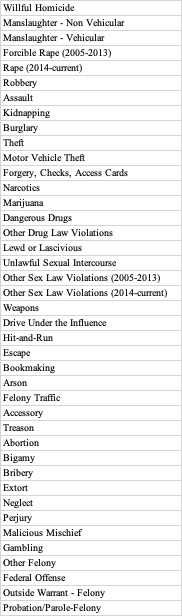) | 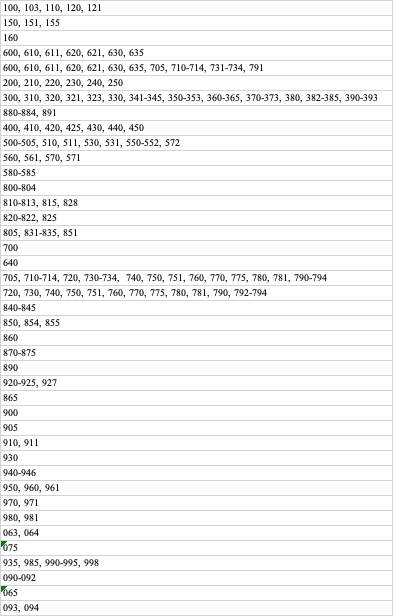 |
|


###Misdemeanor
| Offense | Code |
|---------|:------|
| 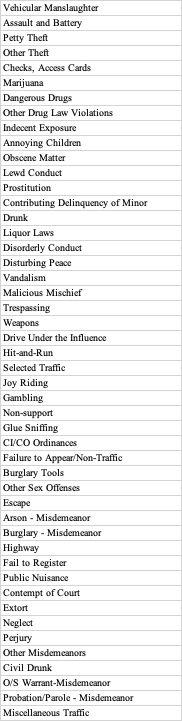 | 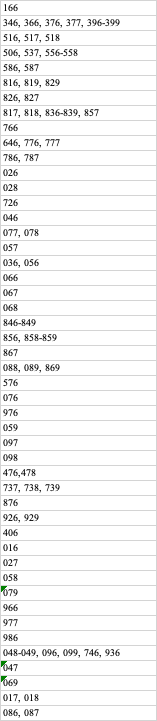 | 
|

###Status Offenses
| Offense | Code |
|---------|:------|
| 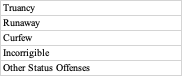 | 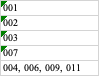 |
|

| Other | Code |
|---------------------------|:-----|
| Unknown or Medical Assist | 000 |

In [ ]:
feloncodes = [
    100, 103, 110, 120, 121, 
    150, 151, 155, 
    160, 
    600, 610, 611, 620, 621, 630, 635, 705, 710, 711, 712, 713, 714, 731, 732, 733, 734, 791,
    200, 210, 220, 230, 240, 250, 
    300, 310, 320, 321, 323, 330, 341, 342, 343, 344, 345, 350, 351, 352, 353, 360, 361, 362, 363, 364, 365, 370, 371, 372, 373, 380, 382, 383, 384, 385, 390, 391, 392, 393, 
    880, 881, 882, 883, 884, 891, 
    400, 410, 420, 425, 430, 440, 450, 
    500, 501, 502, 503, 504, 505, 510, 511, 530, 531, 550, 551, 552, 572,
    560, 561, 570, 571,
    580, 581, 582, 583, 584, 585,
    800, 801, 802, 803, 804,
    810, 811, 812, 813, 815, 828,
    820, 821, 822, 825,
    805, 831, 832, 833, 834, 835, 851,
    700,
    640,
    705, 710, 711, 712, 713, 714, 720, 730, 731, 732, 733, 734,  740, 750, 751, 760, 770, 775, 780, 781, 790, 791, 792, 793, 794,
    840, 841, 842, 843, 844, 845,
    850, 854, 855,
    860,
    870, 871, 872, 873, 874, 875,
    890,
    920, 921, 922, 923, 924, 925, 927,
    865,
    900,
    905,
    910, 911,
    930,
    940, 941, 942, 943, 944, 945, 946,
    950, 960, 961,
    970, 971,
    980, 981,
    63, 64,
    75,
    935, 985, 990, 991, 992, 993, 994, 995, 998,
    90, 91, 92,
    65,
    93, 94 
]

misdecode = [
    166,
    346, 366, 376, 377, 396, 397, 398, 399,
    516, 517, 518,
    506, 537, 556, 357, 558,
    586, 587,
    816, 819, 829,
    826, 827,
    817, 818, 836, 837, 838, 839, 857,
    766,
    646, 776, 777,
    786, 787,
    26,
    28,
    726,
    46,
    77, 78,
    57,
    36, 56,
    66,
    67,
    68,
    846, 847, 848, 849,
    856, 858, 859,
    867,
    88, 89, 869,
    576,
    76,
    976,
    59,
    97,
    98,
    476, 478,
    737, 738, 739,
    876,
    926, 929,
    406,
    16,
    27,
    58,
    79,
    966,
    977,
    986,
    48, 49, 96, 99, 746, 936,
    47,
    69,
    17, 18,
    86, 87
]

statusoffence = [
    1,
    2,
    3,
    7,
    4, 6, 9, 11
]

unkMedAss = [0]

In [ ]:
mlcustody2['custody_offense'] = mlcustody2['custody_offense'].replace(feloncodes, 'Felony')
mlcustody2['custody_offense'] = mlcustody2['custody_offense'].replace(misdecode, 'Misdemeanor/Status Offenses/Unknown or Medical Assist')
mlcustody2['custody_offense'] = mlcustody2['custody_offense'].replace(statusoffence, 'Misdemeanor/Status Offenses/Unknown or Medical Assist')
mlcustody2['custody_offense'] = mlcustody2['custody_offense'].replace(unkMedAss, 'Misdemeanor/Status Offenses/Unknown or Medical Assist')

mlcustody2['custody_offense'] = mlcustody2['custody_offense'].replace({'Felony':1, 'Misdemeanor/Status Offenses/Unknown or Medical Assist':0})

mlcustody2['custody_offense'].value_counts()

1    11380
0      948
Name: custody_offense, dtype: int64

In [ ]:
# mlcustody2 = mlcustody2[mlcustody2["manner_of_death"] != 'Natural']
# mlcustody2["manner_of_death"].value_counts()
# mlcustody2

In [ ]:
mlcustody2 = mlcustody2.reset_index()
columns_to_encode = ['custodial_responsibilty_at_time_of_death',
                     'facility_death_occured',
                     'manner_of_death',
                     'means_of_death',
                     "race"]
ohe = OneHotEncoder()
ohe.fit(mlcustody2[columns_to_encode])
encoded_columns = ohe.transform(mlcustody2[columns_to_encode]).toarray()
encoded_df = pd.DataFrame(encoded_columns, columns=ohe.get_feature_names_out(columns_to_encode))
              

In [ ]:
encoded_df = encoded_df.set_index(mlcustody2.index)

In [ ]:
mlcustody_final = pd.concat([mlcustody2, encoded_df], axis=1)
mlcustody_final.drop(["date_of_death","county","custodial_responsibilty_at_time_of_death","facility_death_occured","manner_of_death","means_of_death"],axis = 1,inplace = True)
mlcustody_final.dtypes

record_key_number                                                              int64
reporting_agency                                                               int64
race                                                                          object
age                                                                            int64
custody_offense                                                                int64
Total Population                                                             float64
 CES 4.0 Percentile                                                          float64
Ozone Pctl                                                                   float64
Tox. Release                                                                 float64
Solid Waste                                                                  float64
Pollution Burden                                                             float64
Education                                                        

 # __Machine Learning Modeling:__
 Now that we have prepared our data, making sure all our features are numeric, we are ready to start implementing some machine learning models.  We will be conducting both classificaion and regression modeling for this dataset since we have two columns that will work well as target variables. 

 ## Classfication Models:
We will be running multi class classificaion models on the Race column to see if we can predict the race of the decseaed based off our features.  If we have good accuracy for these models, we will check which features are the most predictive to show if there are sytematic issues that can be addressed.  
We will be testing each of the models below to see which has the best accuracy and which can tell us the most about the data using feature importance. 

 
1. k-Nearest Neighbors.
2. Decision Trees.
3. Naive Bayes.
4. Random Forest.
5. Gradient Boosting.
6. Support Vector Classifier 


###Correlation Matrix of Merged Data

In [ ]:
corr_matrix = mlcustody_final.corr()

fig = px.imshow(corr_matrix)
fig.layout.autosize = True
fig.layout.height = 1500
fig.layout.width = 1500

#fig.write_html("/content/drive/MyDrive/Grad School/BDA 600/BDA 600 Project/corr_plot.html")
fig.show()

In [ ]:
race_dict = {"White": 0, "Hispanic":1, "Black":2, "Other":3}
mlcustody_final["race"] = mlcustody_final["race"].replace(race_dict)
mlcustody2["reporting_agency"].value_counts()

2    7517
1    2980
0    1831
Name: reporting_agency, dtype: int64

#Predicting by Age

In [ ]:
#mlcustody_final.columns

In [ ]:
#Splitting up the features and the target variable

# X = mlcustody_final.loc[:, mlcustody_final.columns != "reporting_agency"]
# X = X.drop(["race"], axis = 1)

# y = mlcustody_final.loc[:, mlcustody_final.columns == "reporting_agency"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
age_pred_data = mlcustody_final.drop(['Total Population', ' CES 4.0 Percentile',
       'Ozone Pctl', 'Tox. Release', 'Solid Waste', 'Pollution Burden',
       'Education', 'Linguistic Isolation', 'Poverty', 'Unemployment',
       'Housing Burden', 'Hispanic (%)', 'White (%)',
       'African American (%)', 'Native American (%)', 'Asian American (%)',
       'Other/Multiple (%)'], axis =1 )

X = age_pred_data.loc[:, age_pred_data.columns != "age"]


y = age_pred_data.loc[:, age_pred_data.columns == "age"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#--------------------------------------------------------------------------------------------------
#X = mlcustody_final.loc[:, mlcustody_final.columns != "age"]

#y = mlcustody_final.loc[:, mlcustody_final.columns == "age"]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

R Square and MSE

In [ ]:
rfr = RandomForestRegressor(max_depth=2, random_state=0)

preds = rfr.fit(X_train, y_train).predict(X_test)

rfr_cv_score_mse = cross_val_score(rfr, X, y, cv=10,scoring = "neg_mean_squared_error")
rfr_cv_score_r2 = cross_val_score(rfr, X, y, cv=10,scoring = "r2")

print("MSE: ", mean_squared_error(y_test,preds), " R2: ", r2_score(y_test,preds))
print(" ")
print("MSE CV Score: ", np.mean(rfr_cv_score_mse))
print("R2 CV Score: ", np.mean(rfr_cv_score_r2))

MSE:  -164.9127650867461
R2:  0.2979392189093893
 
168.3954987853973 0.379791850255634


In [ ]:
reg = LinearRegression().fit(X, y)

print("Score: ", reg.score(X, y))

lr_cv_score_mse = cross_val_score(reg, X, y, cv=10,scoring = "neg_mean_squared_error")
lr_cv_score_r2 = cross_val_score(reg, X, y, cv=10,scoring = "r2")

print("MSE: ", mean_squared_error(y_test,preds), " R2: ", r2_score(y_test,preds))
print(" ")
print("MSE: ", np.mean(lr_cv_score_mse))
print("R2: ", np.mean(lr_cv_score_r2))

Score:  0.44542727160308226
MSE:  -150.27963972350636
R2:  0.3592371351506279
 
146.25178098995113 0.4613481527781692


In [ ]:
#dtc = DecisionTreeRegressor(random_state=0)
#dtc_cv_score = cross_val_score(dtc, X, y, cv=10)
#print(np.mean(dtc_cv_score))
#dtc.fit(X,y).feature_importances_

dtc = DecisionTreeRegressor(random_state=0)
preds = dtc.fit(X_train, y_train).predict(X_test)

dtc_cv_score_mse = cross_val_score(dtc, X, y, cv=10,scoring = "neg_mean_squared_error")
dtc_cv_score_r2 = cross_val_score(dtc, X, y, cv=10,scoring = "r2")

print("MSE: ", mean_squared_error(y_test,preds), " R2: ", r2_score(y_test,preds))
print(" ")
print("MSE: ", np.mean(dtc_cv_score_mse))
print("R2: ", np.mean(dtc_cv_score_r2))

MSE:  -313.1717546291908
R2:  -0.3355441359867887
 
289.53861129136925 -0.06638364851677014


In [ ]:
svr = make_pipeline(StandardScaler(), SVR(gamma='auto'))

preds = svr.fit(X_train,y_train).predict(X_test)

svr_cv_score_mse = cross_val_score(svr, X, y, cv=10,scoring = "neg_mean_squared_error")
svr_cv_score_r2 = cross_val_score(svr, X, y, cv=10,scoring = "r2")

print("MSE: ", mean_squared_error(y_test,preds), " R2: ", r2_score(y_test,preds))
print(" ")
print("MSE: ", np.mean(svr_cv_score_mse))
print("R2: ", np.mean(svr_cv_score_r2))

MSE:  -148.03653583648043
R2:  0.3679061056955049
 
146.25178098995113 0.4613481527781692


In [ ]:
cross_val = {'Name' : ['Random Forest Regressor', 'Linear Regressor', 'Decision Tree Regressor', 'Support Vector Regression'],
             'Mean Squared Error' : [168.3954987853973, 146.25178098995113, 289.53861129136925, 146.25178098995113],
             'R-Squared Score' : [0.379791850255634, 0.4613481527781692, -0.06638364851677014, 0.4613481527781692],
             'CV Score - MSE' : [-164.9127650867461, -150.27963972350636, -313.1717546291908, -148.03653583648043],
             'CV Score R-Squared' : [0.2979392189093893, 0.3592371351506279, -0.3355441359867887, 0.3679061056955049]
             }

df_crossVal = pd.DataFrame(cross_val)
df_crossVal

,Name,Mean Squared Error,R-Squared Score,CV Score - MSE,CV Score R-Squared
0,Random Forest Regressor,168.395499,0.379792,-164.912765,0.297939
1,Linear Regressor,146.251781,0.461348,-150.279640,0.359237
2,Decision Tree Regressor,289.538611,-0.066384,-313.171755,-0.335544
3,Support Vector Regression,146.251781,0.461348,-148.036536,0.367906


###Might Remove - Check Later

In [ ]:
'''knn = KNeighborsClassifier(n_neighbors = 3 )

knn_cv_score = cross_val_score(knn, X, y, cv=10)

# knn.fit(X_train,y_train)
# knn_score = knn.score(X_test,y_test)

print(np.mean(knn_cv_score))'''

0.017034263384628344


In [ ]:
'''gnb = GaussianNB()

gnb_cv_score = cross_val_score(gnb, X, y, cv=10)

print(np.mean(gnb_cv_score))

gnb_preds = gnb.fit(X_train,y_train).predict(X_test)'''

0.009003618036464751


In [ ]:
#getattr(gnb)

In [ ]:
'''rfc = RandomForestClassifier(max_depth=2, random_state=0)

rfc_cv_score = cross_val_score(rfc, X, y, cv=10)

print(np.mean(rfc_cv_score))'''

In [ ]:
'''gbc = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 max_features = "auto", 
                                 random_state=0).fit(X_train, y_train)

gbc_cv_score = cross_val_score(gbc, X, y, cv=10)

print(np.mean(gbc_cv_score))

'''

In [ ]:
'''svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))

svc_cv_score = cross_val_score(svc, X, y, cv=10)

print(np.mean(svc_cv_score))'''

#Predicting by Race

In [ ]:
mlcustody_final.columns

In [ ]:
race_pred_data = mlcustody_final.drop(['race_Black', 'race_Hispanic', 'race_Other', 'race_White', 'date_of_death_yyyy', 'date_of_death_mm',
       'date_of_death_dd', 'Total Population', ' CES 4.0 Percentile',
       'Ozone Pctl', 'Tox. Release', 'Solid Waste', 'Pollution Burden',
       'Education', 'Linguistic Isolation', 'Poverty', 'Unemployment',
       'Housing Burden', 'Children < 10 years (%)', 'Pop 10-64 years (%)',
       'Elderly > 64 years (%)', 'Hispanic (%)', 'White (%)',
       'African American (%)', 'Native American (%)', 'Asian American (%)',
       'Other/Multiple (%)', 'custodial_responsibilty_at_time_of_death_CDC/CRC',
       'custodial_responsibilty_at_time_of_death_Crime Scene',
       'custodial_responsibilty_at_time_of_death_Hospital',
       'custodial_responsibilty_at_time_of_death_Jail',
       'custodial_responsibilty_at_time_of_death_Other',
       'facility_death_occured_CDC/CRC', 'facility_death_occured_Crime Scene',
       'facility_death_occured_Hospital', 'facility_death_occured_Jail',
       'facility_death_occured_Other', 'manner_of_death_Accidental',
       'manner_of_death_Homicide Justified (Law Enforcement Staff & Other Inmate)',
       'manner_of_death_Homicide Willful (Law Enforcement Staff & Other Inmate)',
       'manner_of_death_Natural', 'manner_of_death_Other',
       'manner_of_death_Suicide', 'means_of_death_Drug Overdose',
       'means_of_death_Hanging,Strangulation', 'means_of_death_Not Applicable',
       'means_of_death_Other', 'means_of_death_Weapons of All Manner',], axis =1 )

X = race_pred_data.loc[:, race_pred_data.columns != "race"]


y = race_pred_data.loc[:, race_pred_data.columns == "race"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print(X_train.columns)
print(y_train["race"].value_counts())

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3 )

knn_preds = knn.fit(X_train,y_train).predict(X_test)

knn_cv_score_a = cross_val_score(knn, X, y, cv=10, scoring = "accuracy" )
# knn_cv_score_p = cross_val_score(knn, X, y, cv=10, scoring = "precision" )
# knn_cv_score_r = cross_val_score(knn, X, y, cv=10, scoring = "recall" )
# knn_cv_score_f = cross_val_score(knn, X, y, cv=10, scoring = "f1" )
# knn_p_score = precision_score(y_test,knn_preds, labels = )

# knn.fit(X_train,y_train)
# knn_score = knn.score(X_test,y_test)

print(np.mean(knn_cv_score_a))
# print(np.mean(knn_cv_score_p))
# print(np.mean(knn_cv_score_r))
# print(np.mean(knn_cv_score_f))

print(classification_report(y_test,knn_preds, target_names = ["Black","Hispanic","Other","White"]))

conf_matrix = confusion_matrix( y_test,knn_preds)
print(conf_matrix)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Black","Hispanic","Other","White"])
disp.plot()
plt.show()

In [ ]:
gnb = GaussianNB()

gnb_cv_score = cross_val_score(gnb, X, y, cv=10)

print(np.mean(gnb_cv_score))

gnb_preds = gnb.fit(X_train,y_train).predict(X_test)

print(classification_report(y_test,gnb_preds, target_names = ["Black","Hispanic","Other","White"]))

conf_matrix = confusion_matrix(y_test,gnb_preds)
print(conf_matrix)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Black","Hispanic","Other","White"])
disp.plot()
plt.show()

In [ ]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)

rfc_cv_score = cross_val_score(rfc, X, y, cv=10)

rfc_preds = rfc.fit(X_train,y_train).predict(X_test)

print(classification_report(y_test,rfc_preds, target_names = ["Black","Hispanic","Other","White"]))


print(np.mean(rfc_cv_score))

conf_matrix = confusion_matrix(y_test,rfc_preds)
print(conf_matrix)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Black","Hispanic","Other","White"])
disp.plot()
plt.show()

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 max_features = "auto", 
                                 random_state=0).fit(X_train, y_train)

gbc_cv_score = cross_val_score(gbc, X, y, cv=10)

print(np.mean(gbc_cv_score))

gbc_fit = gbc.fit(X_train,y_train)
gbc_preds =gbc_fit.predict(X_test)
gbc_proba = gbc_fit.predict_proba(X_test)


conf_matrix = confusion_matrix(y_test,gbc_preds)
print(conf_matrix)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Black","Hispanic","Other","White"])
disp.plot()
plt.show()

In [ ]:
svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))

svc_cv_score = cross_val_score(svc, X, y, cv=10)

print(np.mean(svc_cv_score))


svc_preds = svc.fit(X_train,y_train).predict(X_test)

conf_matrix = confusion_matrix(y_test,svc_preds)
print(conf_matrix)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Black","Hispanic","Other","White"])
disp.plot()
plt.show()

#Predicting by Agency

In [ ]:
agency_pred_data = mlcustody_final.drop([ 'date_of_death_yyyy', 'date_of_death_mm',
       'date_of_death_dd', 'Total Population', ' CES 4.0 Percentile',
       'Ozone Pctl', 'Tox. Release', 'Solid Waste', 'Pollution Burden',
       'Education', 'Linguistic Isolation', 'Poverty', 'Unemployment',
       'Housing Burden', 'Children < 10 years (%)', 'Pop 10-64 years (%)',
       'Elderly > 64 years (%)', 'Hispanic (%)', 'White (%)',
       'African American (%)', 'Native American (%)', 'Asian American (%)',
       'Other/Multiple (%)', 'sentenced'], axis =1 )

X = agency_pred_data.loc[:, agency_pred_data.columns != "reporting_agency"]


y = agency_pred_data.loc[:, agency_pred_data.columns == "reporting_agency"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3 )

knn_preds = knn.fit(X_train,y_train).predict(X_test)

knn_cv_score = cross_val_score(knn, X, y, cv=10)

# knn.fit(X_train,y_train)
# knn_score = knn.score(X_test,y_test)

print(np.mean(knn_cv_score))
conf_matrix = confusion_matrix(y_test,knn_preds)
print(conf_matrix)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Local Police", "Sheriff", "State Police"])
disp.plot()
plt.show()

In [ ]:
gnb = GaussianNB()

gnb_cv_score = cross_val_score(gnb, X, y, cv=10)

print(np.mean(gnb_cv_score))

gnb_preds = gnb.fit(X_train,y_train).predict(X_test)


conf_matrix = confusion_matrix(y_test,gnb_preds)
print(conf_matrix)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Local Police", "Sheriff", "State Police"])
disp.plot()
plt.show()

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 max_features = "auto", 
                                 random_state=0).fit(X_train, y_train)

#gbc_cv_score = cross_val_score(gbc, X, y, cv=10)



print(np.mean(gbc_cv_score))

gbc_preds = gbc.fit(X_train,y_train).predict(X_test)

print(classification_report(y_test,gbc_preds, target_names = ["Local Police", "Sheriff", "State Police"]))

conf_matrix = confusion_matrix(y_test,gbc_preds)
print(conf_matrix)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Local Police", "Sheriff", "State Police"])
disp.plot()
plt.show()

In [ ]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)

rfc_cv_score = cross_val_score(rfc, X, y, cv=10)

rfc_preds = rfc.fit(X_train,y_train).predict(X_test)



print(np.mean(rfc_cv_score))

conf_matrix = confusion_matrix(y_test,rfc_preds)
print(conf_matrix)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Local Police", "Sheriff", "State Police"])
disp.plot()
plt.show()

In [ ]:
svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))

svc_cv_score = cross_val_score(svc, X, y, cv=10)

print(np.mean(svc_cv_score))


svc_fit = svc.fit(X_train,y_train)

svc_preds = svc_fit.predict(X_test)
svc_proba = svc_fit.predict_proba(X_test)

conf_matrix = confusion_matrix(y_test,svc_preds)
print(conf_matrix)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Local Police", "Sheriff", "State Police"])
disp.plot()
plt.show()

# Exploring More of the Data:

Now that we have finished most of what we want to do with our data including manipulation for ML Models. Here we looked into making a new data frame that looks at the death rate of each county per 100,000 people. The data is normalized and scaled. This new infromation  uses the full populatio count of each county from the CalEnviScreen data set and the total deaths per a county from the DeathCustody dataset.

In [ ]:
deathCount = len(deathCustody)
print("Each data point is a death and there are {} deaths, and so we will look the amount of deaths per an agency.".format(deathCount))

In [ ]:
#count the number of occurrences of each agency name
countyDeaths = deathCustody['county'].value_counts() #.sort_values(ascending=True)
countyDeaths = countyDeaths.sort_index() #Make it in alphabetical order with sort_index() for proper normaliziation
countyDeaths

I will be counting the population count per a county using the other data set, the calenviroscreen40resultsdatadictionary_F_2021.xlsx file. This will be used to normalize the death count per county for the other dataset. Some models require normalization as well in order to avoid the vanishing gradient problem during the training phase. If you train a model (such as linear regression) without previous normalization, you can't use the coefficients as indicators of feature importance.

In [ ]:
# Aggregate population by county
countyPop = calEnvi.groupby('California County').sum()['Total Population']
# Print the population counts by county
countyPop = countyPop.sort_values(ascending=False)
countyPop = countyPop.sort_index()
countyPop

In [ ]:
#Need to check if there are any Null values in these two variables, due to some erros with trying to normalize the data.
#May remove later
print(countyDeaths.isnull().sum())
print(countyPop.isnull().sum())

0
0


Below this chunk of code is used first remove all white space for the row names of the counties so that they can be concated properly. Then we proceed to concat the two dataFrames. I have then noticed that there are some values of 0 in the Death and Population columns. I would need to remove these to not negatively affect our analysis and vizulization later on. We make sure to group them in order with groupby().

In [ ]:
#Merging counties that are from the previous 2 dataframes of CountyDeaths and CountyPopulation that will be used for normilization
countyDeaths.index = countyDeaths.index.str.strip()
countyPop.index = countyPop.index.str.strip()
mergedCounty = pd.concat([countyDeaths, countyPop], axis=1, join='outer', sort=True)
mergedCounty = mergedCounty.groupby(mergedCounty.index).sum()
mergedCounty.columns = ['Deaths', 'Population']
print("The amount of Counties here: {}".format(len(mergedCounty)))
mergedCounty

The amount of Counties here: 60


,Deaths,Population
Alameda,240.0,1656754.0
Alpine,0.0,1039.0
Amador,189.0,38429.0
Butte,45.0,225817.0
Calaveras,4.0,45514.0
Colusa,1.0,21454.0
Contra Costa,85.0,1142251.0
Del Norte,62.0,27495.0
El Dorado,20.0,188563.0
Fresno,482.0,984521.0


In [ ]:
print(id(mergedCounty))

In [ ]:
#this code is removing the rows with 0 values
mergedCounty = mergedCounty.loc[(mergedCounty['Deaths'] != 0) & (mergedCounty['Population'] != 0)]
print("The amount of Counties here: {}".format(len(mergedCounty)))
mergedCounty

The amount of Counties here: 56


,Deaths,Population
Alameda,240.0,1656754.0
Amador,189.0,38429.0
Butte,45.0,225817.0
Calaveras,4.0,45514.0
Colusa,1.0,21454.0
Contra Costa,85.0,1142251.0
Del Norte,62.0,27495.0
El Dorado,20.0,188563.0
Fresno,482.0,984521.0
Glenn,3.0,27976.0


In [ ]:
# Divide the number of deaths by the total population for each county and multiply by 100,000
# Calculate death rate per 100,000 population
mergedCounty['DeathRate'] = mergedCounty['Deaths'] / mergedCounty['Population'] * 100000

# Standardize the data
scaler = StandardScaler()
mergedCounty['DeathRateScaled'] = scaler.fit_transform(mergedCounty[['DeathRate']])
#mergedCounty = mergedCounty.rename_axis('CountyName').reset_index()
mergedCounty

,Deaths,Population,DeathRate,DeathRateScaled
Alameda,240.0,1656754.0,14.486158,-0.437202
Amador,189.0,38429.0,491.816076,3.475062
Butte,45.0,225817.0,19.927641,-0.392603
Calaveras,4.0,45514.0,8.788505,-0.483901
Colusa,1.0,21454.0,4.661135,-0.517729
Contra Costa,85.0,1142251.0,7.441447,-0.494941
Del Norte,62.0,27495.0,225.495545,1.292261
El Dorado,20.0,188563.0,10.606535,-0.469000
Fresno,482.0,984521.0,48.957818,-0.154667
Glenn,3.0,27976.0,10.723477,-0.468041


In [ ]:
list(mergedCounty)

In [ ]:
copyOrignMerge = copy(mergedCounty)
print(id(copyOrignMerge))
copyOrignMerge

139765236424928


,Deaths,Population,DeathRate,DeathRateScaled
Alameda,240.0,1656754.0,14.486158,-0.437202
Amador,189.0,38429.0,491.816076,3.475062
Butte,45.0,225817.0,19.927641,-0.392603
Calaveras,4.0,45514.0,8.788505,-0.483901
Colusa,1.0,21454.0,4.661135,-0.517729
Contra Costa,85.0,1142251.0,7.441447,-0.494941
Del Norte,62.0,27495.0,225.495545,1.292261
El Dorado,20.0,188563.0,10.606535,-0.469000
Fresno,482.0,984521.0,48.957818,-0.154667
Glenn,3.0,27976.0,10.723477,-0.468041


In [ ]:
clist = ['Alameda', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa',
       'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial',
       'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera',
       'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey',
       'Napa', 'Nevada', 'Orange', 'Placer', 'Riverside', 'Sacramento',
       'San Benito', 'San Bernardino', 'San Diego', 'San Francisco',
       'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara',
       'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano',
       'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare',
       'Tuolumne', 'Ventura', 'Yolo', 'Yuba']

In [ ]:
copyOrignMerge['California County'] = clist
copyOrignMerge

,Deaths,Population,DeathRate,DeathRateScaled,California County
Alameda,240.0,1656754.0,14.486158,-0.437202,Alameda
Amador,189.0,38429.0,491.816076,3.475062,Amador
Butte,45.0,225817.0,19.927641,-0.392603,Butte
Calaveras,4.0,45514.0,8.788505,-0.483901,Calaveras
Colusa,1.0,21454.0,4.661135,-0.517729,Colusa
Contra Costa,85.0,1142251.0,7.441447,-0.494941,Contra Costa
Del Norte,62.0,27495.0,225.495545,1.292261,Del Norte
El Dorado,20.0,188563.0,10.606535,-0.469000,El Dorado
Fresno,482.0,984521.0,48.957818,-0.154667,Fresno
Glenn,3.0,27976.0,10.723477,-0.468041,Glenn


###Creating a New Export File of this dataset for Visualization purposes

A brief excerpt of code the develop a new CSV file of the manipulated data. This created a death rate per 100,000 people per the population of the whole county. It also includes the scaled data as well.

In [ ]:
#Exporting newly manipulated data for usage on other visualization tools
copyOrignMerge.to_csv('/content/drive/MyDrive/BDA 600 - Project/deathrate_calicounty.csv', index=False)

Creating another dataset that combines the death and deathrate dataset made previously with the california Environmental dataset by counties.

In [ ]:
copyOrignMerge

In [ ]:
calEnvi2 = calEnvi.drop(["Census Tract", 'Total Population', ' CES 4.0 Percentile'],axis = 1).groupby("California County").mean()
calEnvi2.reset_index(inplace=True)

calEnvi2

In [ ]:
copyOrignMerge['California County'] = copyOrignMerge['California County'].str.strip()
calEnvi2['California County'] = calEnvi2['California County'].str.strip()

deathsEnvi = calEnvi2.merge(copyOrignMerge, on = "California County",how = "left")
deathsEnvi["California County"] = deathsEnvi["California County"].str.strip()

#deathsEnvi_avgs = deathsEnvi.drop("Census Tract",axis = 1).groupby("California County").mean()
#deathsEnvi.reset_index(inplace = True)

print('Shape: ', deathsEnvi.shape)
print('NaN Total: ', deathsEnvi.isna().sum().sum())

deathsEnvi

In [ ]:
#Deleting the NaN valued rows
deathsEnvi = deathsEnvi.drop(deathsEnvi.index[31])
deathsEnvi = deathsEnvi.drop(deathsEnvi.index[1])

# assign new index from 1 to 56
deathsEnvi.index = pd.RangeIndex(start=1, stop=1+len(deathsEnvi), step=1)

deathsEnvi

# Visualizations to create:

- Deaths normalized by the race %
- deaths per county (normalized)
- deaths per agency



time series:
- deaths per agency over time
- deaths in each race over time (normailzed?)



#Data Visualization

We will be looking into creating different visualizations for the newly manipulated and cleaned datasets we have. Looking at relations between different attributes of Death in Custody and Measurements of Californian Social and Economical reportings (i.e. Poverty, unemployment levels and ethnicity and gender).


## Data viz ideas:
* show race levels for each county and then the death levels for each of those races to see if there is any stand out counties based off their percentage population. 

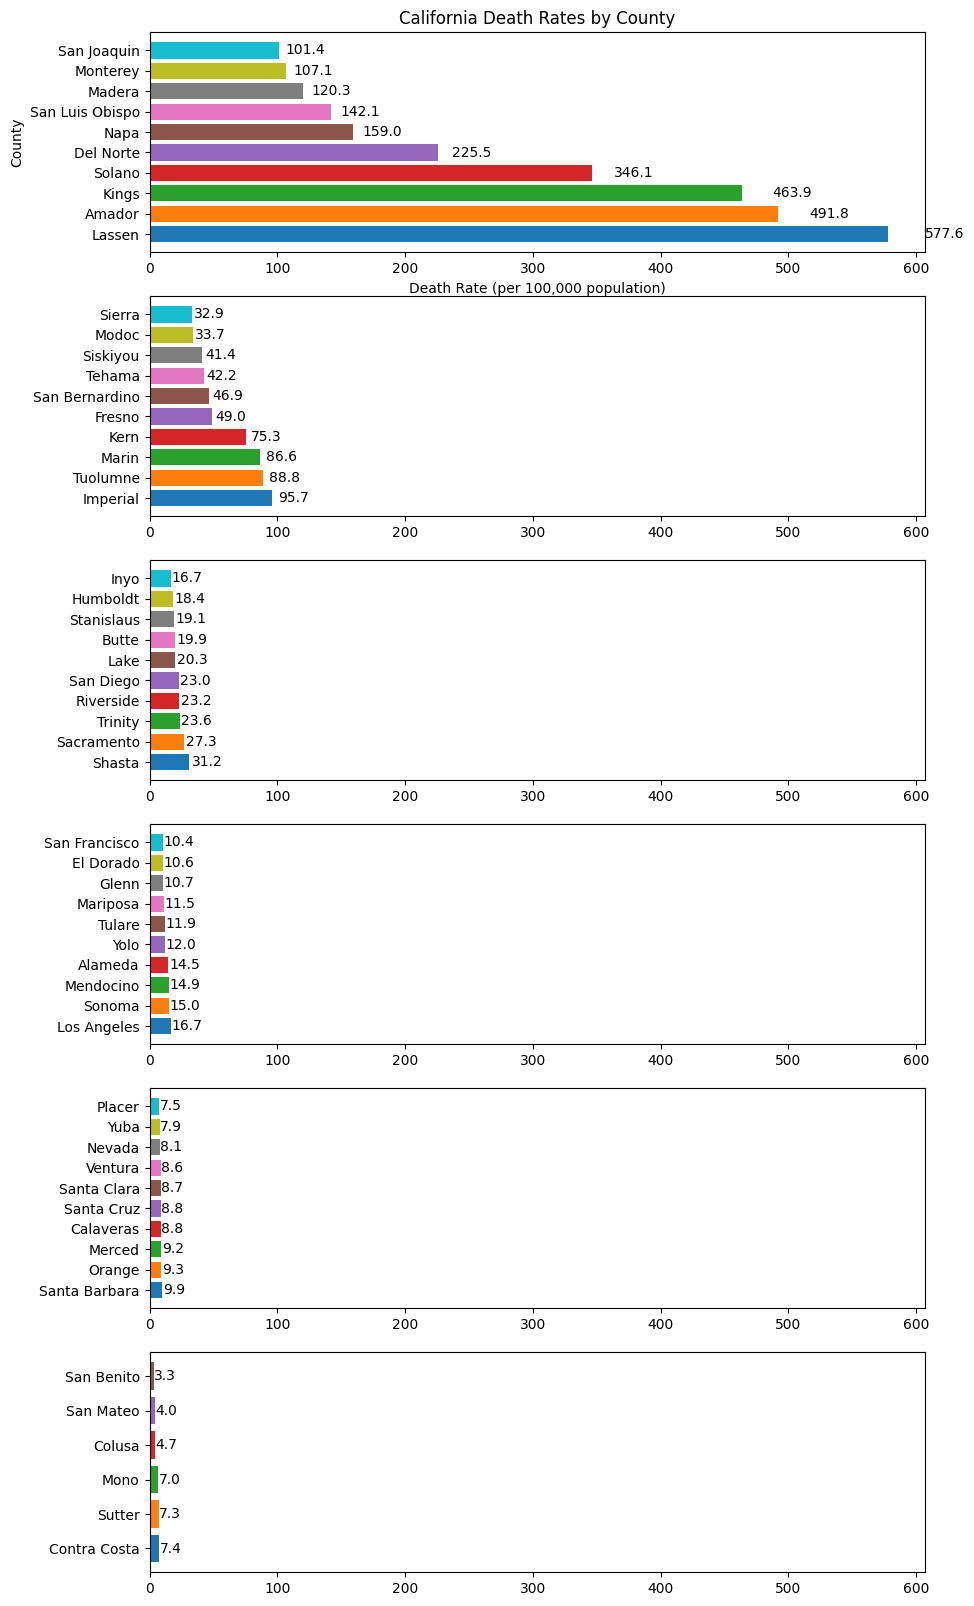

In [ ]:
# Sort counties by death rate
mergedCounty = mergedCounty.sort_values(by='DeathRate', ascending=False)

# Create multiple subplots for each group of 10 counties
fig, axs = plt.subplots(nrows=math.ceil(len(mergedCounty)/10), ncols=1, figsize=(10,20))
# Set axis labels and title for the last subplot
axs[0].set_xlabel('Death Rate (per 100,000 population)')
axs[0].set_ylabel('County')
axs[0].set_title('California Death Rates by County')
# Loop through the data and create a horizontal bar chart for each group of 10 counties
for i, (index, row) in enumerate(mergedCounty.iterrows()):
    ax = axs[i//10]
    ax.barh(index, row['DeathRate'])
    ax.set_xlim(0, mergedCounty['DeathRate'].max()*1.05)

    # Add the death rate value next to the bar
    ax.text(row['DeathRate']*1.05, index, f"{row['DeathRate']:.1f}", va='center')

plt.savefig('CaliforniaDeathRatesCounty.png')
plt.show()

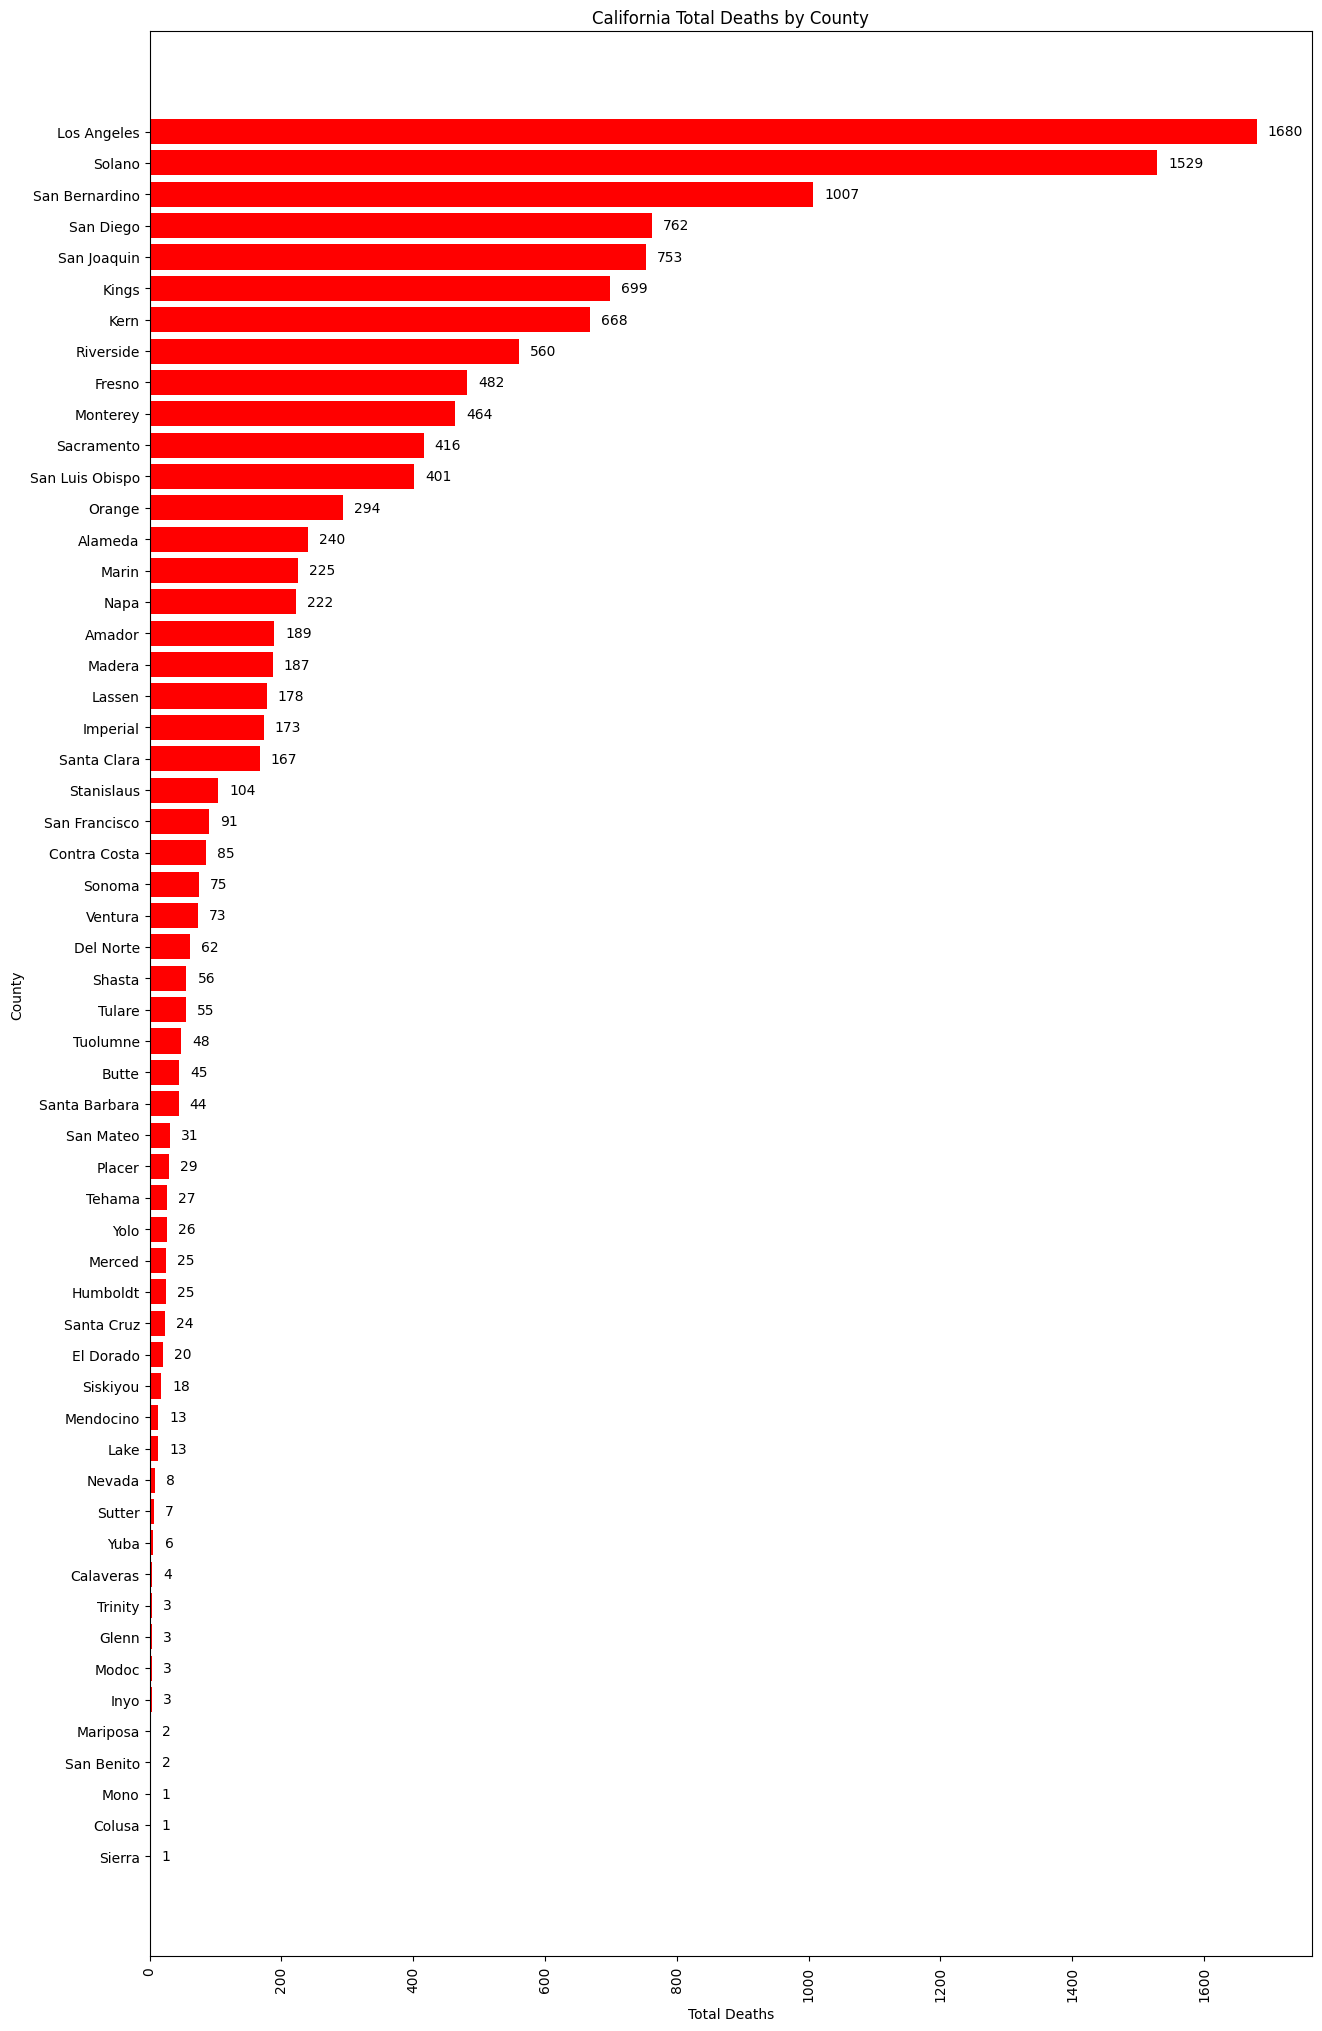

In [ ]:
#Visualize the total number of deaths in each county. This is for comparing the death rates across different counties.
# Sort counties by death rate
mergedCounty = mergedCounty.sort_values(by='Deaths', ascending=True)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(15,25))
bars = ax.barh(mergedCounty.index, mergedCounty['Deaths'], color='red')

# Add text labels on top of each bar
for bar in bars:
    value = bar.get_width()
    x_pos = value + mergedCounty['Deaths'].max() * 0.01
    y_pos = bar.get_y() + bar.get_height() / 2
    ax.text(x_pos, y_pos, f'{value:.0f}', va='center', ha='left')

# Set axis labels and title
ax.set_xlabel('Total Deaths')
ax.set_ylabel('County')
ax.set_title('California Total Deaths by County')

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.savefig('CaliforniaTotalDeathsCounty.png')
plt.show()

In [ ]:
# Set up the figure
fig = go.Figure()

# Add the death rate bar trace
fig.add_trace(go.Bar(
    y=mergedCounty.index,
    x=mergedCounty['DeathRate'],
    name='Death Rate',
    orientation='h',
    marker=dict(color='#2B2D42')
))

# Add the population bar trace
fig.add_trace(go.Bar(
    y=mergedCounty.index,
    x=mergedCounty['Population'],
    name='Population',
    orientation='h',
    marker=dict(color='#8D99AE')
))

# Update the layout
fig.update_layout(
    title='California County Death Rates and Populations',
    xaxis_title='Rate / Population',
    yaxis_title='County',
    barmode='group',
    bargap=0.1,
    height=800
)

#fig.write_html("/content/drive/MyDrive/BDA 600 - Project/horizontalbar_countydeathrate-population.html")
# Show the figure
fig.show()

In [ ]:
copyCustody = copy(mlcustody)
print(id(copyCustody))
print(id(mlcustody))
copyCustody.head(5)

In [ ]:
# Organizing the Race Column

other_ethn = ['Other Asian', 
              'Filipino', 
              'Vietnamese', 
              'Asian Indian', 
              'Pacific Islander',
              'Korean', 
              'Chinese', 
              'Laotian', 
              'Samoan', 
              'Cambodian', 
              'Japanese',  
              'Guamanian',
              'Hawaiian', ]


copyCustody['race'] = copyCustody['race'].replace(other_ethn, "Asian/Pacific Islander")

copyCustody = copyCustody[copyCustody['age'].str.isnumeric()]
copyCustody['age'] = copyCustody['age'].astype(str).astype(int)

copyCustody['race'].value_counts()

In [ ]:
#Box Plot
fig = px.box(copyCustody, x='race', y='age', color='gender')
#fig.write_html("/content/drive/MyDrive/BDA 600 - Project/boxplot_ageracegender.html")
fig.show()

In [ ]:
#Scatter Plot
fig = px.scatter(deathsEnvi, x='Unemployment', y='Poverty', color='DeathRate', size='Deaths', hover_data=['Tox. Release','Linguistic Isolation', 'Education', 'California County'])
#fig.write_html("/content/drive/MyDrive/BDA 600 - Project/scatterplot_countydetails.html")
fig.show()

In [ ]:
#Histogram
fig = px.histogram(mlcustody, x='age', nbins=20, marginal='box')
#fig.write_html("/content/drive/MyDrive/BDA 600 - Project/histogramboxplot_age.html")
fig.show()

In [ ]:
viz_data = merged_data

Asian_American = ['Other Asian', 
              'Filipino', 
              'Vietnamese', 
              'Asian Indian', 
              'Pacific Islander',
              'Korean', 
              'Chinese', 
              'Laotian', 
              'Samoan', 
              'Cambodian', 
              'Japanese', 
              'Guamanian',
      ]
Native_American = ["American Indian","Hawaiian"]

viz_data["race"]= viz_data["race"].replace(Native_American,"Native American")
viz_data["race"]= viz_data["race"].replace(Asian_American,"Asian American")
viz_data["race"]= viz_data["race"].replace("Black","African American")
viz_data["race"].value_counts()


print(viz_data[['Asian American (%)',
          'African American (%)', 
          'Hispanic (%)', 
          'Native American (%)',
          'Other/Multiple (%)',
          'White (%)', ]].mean())

# Define the population percentages by race, this information was taken from the result above
pop_percentages = {
    'Hispanic': 39.489592,
    'African American': 6.356513,
    'White': 39.905815,
    'Other': 3.409388,
    'Asian American': 10.298663,
    'Native American': 0.540274
}

viz_no_natural = viz_data[viz_data["manner_of_death"] != "Natural"]
viz_no_state = viz_data[viz_data["reporting_agency"] != "State"]

In [ ]:
total_deaths_by_race = viz_data.groupby('race')['record_key_number'].count()

In [ ]:
state_race_percentages = viz_data[['Asian American (%)',
          'African American (%)', 
          'Hispanic (%)', 
          'Native American (%)',
          'Other/Multiple (%)',
          'White (%)', 
]].mean()

In [ ]:
#Change name of Race (%) -> Race for proper concatination
state_race_percentages = state_race_percentages.rename({
    'African American (%)': 'African American', 
    'Asian American (%)': 'Asian American',
    'Hispanic (%)': 'Hispanic',
    'Native American (%)': 'Native American',
    'Other/Multiple (%)': 'Other/Multiple',
    'White (%)': 'White'})

total_deaths_by_race = total_deaths_by_race.rename({'Other': 'Other/Multiple'})

race_percent = pd.concat((total_deaths_by_race, state_race_percentages), axis=1)
race_percent.rename(columns={'record_key_number': 'Total Deaths', 0: 'State Percentage'}, inplace=True)

race_percent

In [ ]:
print(total_deaths_by_race)
print(" ")
print(state_race_percentages)

In [ ]:
deaths_by_race = viz_data.groupby(['race'])[['record_key_number']].count()
deaths_by_race = deaths_by_race.reset_index()

deaths_by_race['pop_percentage'] = deaths_by_race['race'].map(pop_percentages)
deaths_by_race['normalized_deaths'] = deaths_by_race['record_key_number'] / (deaths_by_race['pop_percentage'] )

deaths_by_race = deaths_by_race.sort_values("normalized_deaths", ascending = False)

fig = px.bar(x=deaths_by_race["race"], y = deaths_by_race['normalized_deaths'])
#fig.write_html("/content/drive/MyDrive/BDA 600 - Project/bargraph_race_normalized.html")
fig.show()

##Time Series Visualization

In [ ]:
# Group the data by race and month
viz_data['month_of_death'] = viz_data['date_of_death'].dt.strftime('%Y-%m')
deaths_by_agency_and_month = viz_data.groupby(['custodial_responsibilty_at_time_of_death', 'month_of_death'])[['record_key_number']].count()
deaths_by_agency_and_month = deaths_by_agency_and_month.reset_index()

# Create an interactive line plot of the total number of deaths for each race over time
fig = go.Figure()
for race in deaths_by_agency_and_month['custodial_responsibilty_at_time_of_death'].unique():
    df_race = deaths_by_agency_and_month[deaths_by_agency_and_month['custodial_responsibilty_at_time_of_death'] == race]
    fig.add_trace(go.Scatter(x=df_race['month_of_death'], y=df_race['record_key_number'], mode='lines', name=race))

fig.update_layout(title='Monthly Deaths in Custody by Custodial Responsibly', xaxis_title='Year', yaxis_title='Number of Deaths')
fig.write_html("/content/drive/MyDrive/Grad School/BDA 600/BDA 600 Project/deaths_by_custodial_responsibilty.html")
fig.show()

In [ ]:
# Group the data by race and month
viz_data['month_of_death'] = viz_data['date_of_death'].dt.strftime('%Y-%m')
deaths_by_agency_and_month = viz_data.groupby(['reporting_agency', 'month_of_death'])[['record_key_number']].count()
deaths_by_agency_and_month = deaths_by_agency_and_month.reset_index()

# Create an interactive line plot of the total number of deaths for each race over time
fig = go.Figure()
for race in deaths_by_agency_and_month['reporting_agency'].unique():
    df_race = deaths_by_agency_and_month[deaths_by_agency_and_month['reporting_agency'] == race]
    fig.add_trace(go.Scatter(x=df_race['month_of_death'], y=df_race['record_key_number'], mode='lines', name=race))

fig.update_layout(title='Monthly Deaths in Custody by Agency', xaxis_title='Year', yaxis_title='Number of Deaths')
fig.write_html("/content/drive/MyDrive/Grad School/BDA 600/BDA 600 Project/deaths_by_agency.html")
fig.show()



viz_no_natural['month_of_death'] = viz_no_natural['date_of_death'].dt.strftime('%Y-%m')
deaths_by_agency_and_month = viz_no_natural.groupby(['reporting_agency', 'month_of_death'])[['record_key_number']].count()
deaths_by_agency_and_month = deaths_by_agency_and_month.reset_index()

# Create an interactive line plot of the total number of deaths for each race over time
fig2 = go.Figure()
for race in deaths_by_agency_and_month['reporting_agency'].unique():
    df_race = deaths_by_agency_and_month[deaths_by_agency_and_month['reporting_agency'] == race]
    fig2.add_trace(go.Scatter(x=df_race['month_of_death'], y=df_race['record_key_number'], mode='lines', name=race))

fig2.update_layout(title='Monthly Deaths in Custody by Agency (No Natural Deaths)', xaxis_title='Year', yaxis_title='Number of Deaths')
fig2.write_html("/content/drive/MyDrive/Grad School/BDA 600/BDA 600 Project/deaths_by_agency_no_natural.html")
fig2.show()

In [ ]:
# Group the data by race and month
viz_data['month_of_death'] = viz_data['date_of_death'].dt.strftime('%Y-%m')
deaths_by_race_and_month = viz_data.groupby(['race', 'month_of_death'])[['record_key_number']].count()
deaths_by_race_and_month = deaths_by_race_and_month.reset_index()

# Normalize the number of deaths by population percentage for each race
deaths_by_race_and_month['pop_percentage'] = deaths_by_race_and_month['race'].map(pop_percentages)
deaths_by_race_and_month['normalized_deaths'] = deaths_by_race_and_month['record_key_number'] / (deaths_by_race_and_month['pop_percentage'] / 100)

# Create an interactive line plot of the normalized number of deaths for each race over time
fig = go.Figure()
for race in deaths_by_race_and_month['race'].unique():
    df_race = deaths_by_race_and_month[deaths_by_race_and_month['race'] == race]
    fig.add_trace(go.Scatter(x=df_race['month_of_death'], y=df_race['normalized_deaths'], mode='lines', name=race))

fig.update_layout(title='Monthly Deaths in Custody by Race', xaxis_title='Year', yaxis_title='Deaths (Normalized)')
#fig.write_html("/content/drive/MyDrive/Grad School/BDA 600/BDA 600 Project/deaths_by_race.html")

fig.show()

# Create an interactive line plot of the normalized number of deaths for each race over time
fig2 = go.Figure()
for race in deaths_by_race_and_month['race'].unique():
    df_race = deaths_by_race_and_month[deaths_by_race_and_month['race'] == race]
    fig2.add_trace(go.Scatter(x=df_race['month_of_death'], y=df_race['record_key_number'], mode='lines', name=race))

fig2.update_layout(title='Monthly Deaths in Custody by Race', xaxis_title='Year', yaxis_title='Deaths')
fig2.show()

In [ ]:
# Group the data by race and month
viz_no_natural['month_of_death'] = viz_no_natural['date_of_death'].dt.strftime('%Y-%m')
deaths_by_race_and_month = viz_no_natural.groupby(['race', 'month_of_death'])[['record_key_number']].count()
deaths_by_race_and_month = deaths_by_race_and_month.reset_index()

# Normalize the number of deaths by population percentage for each race
deaths_by_race_and_month['pop_percentage'] = deaths_by_race_and_month['race'].map(pop_percentages)
deaths_by_race_and_month['normalized_deaths'] = deaths_by_race_and_month['record_key_number'] / (deaths_by_race_and_month['pop_percentage'] / 100)

# Create an interactive line plot of the normalized number of deaths for each race over time
fig = go.Figure()
for race in deaths_by_race_and_month['race'].unique():
    df_race = deaths_by_race_and_month[deaths_by_race_and_month['race'] == race]
    fig.add_trace(go.Scatter(x=df_race['month_of_death'], y=df_race['normalized_deaths'], mode='lines', name=race))

fig.update_layout(title='Monthly Deaths in Custody by Race (No Natrual Deaths)', xaxis_title='Year', yaxis_title='Deaths (Normalized)')
#fig.write_html("/content/drive/MyDrive/Grad School/BDA 600/BDA 600 Project/deaths_by_race_no_natural.html")
fig.show()



# Create an interactive line plot of the normalized number of deaths for each race over time
fig2 = go.Figure()
for race in deaths_by_race_and_month['race'].unique():
    df_race = deaths_by_race_and_month[deaths_by_race_and_month['race'] == race]
    fig2.add_trace(go.Scatter(x=df_race['month_of_death'], y=df_race['record_key_number'], mode='lines', name=race))

fig2.update_layout(title='Monthly Deaths in Custody by Race (No Natrual Deaths)', xaxis_title='Year', yaxis_title='Deaths')
#fig2.write_html("/content/drive/MyDrive/Grad School/BDA 600/BDA 600 Project/deaths_by_race_no_natural.html")
fig2.show()

In [ ]:
# Group the data by race and month
viz_no_state['month_of_death'] = viz_no_state['date_of_death'].dt.strftime('%Y-%m')
deaths_by_race_and_month = viz_no_state.groupby(['race', 'month_of_death'])[['record_key_number']].count()
deaths_by_race_and_month = deaths_by_race_and_month.reset_index()

# Normalize the number of deaths by population percentage for each race
deaths_by_race_and_month['pop_percentage'] = deaths_by_race_and_month['race'].map(pop_percentages)
deaths_by_race_and_month['normalized_deaths'] = deaths_by_race_and_month['record_key_number'] / (deaths_by_race_and_month['pop_percentage'] / 100)

# Create an interactive line plot of the normalized number of deaths for each race over time
fig = go.Figure()
for race in deaths_by_race_and_month['race'].unique():
    df_race = deaths_by_race_and_month[deaths_by_race_and_month['race'] == race]
    fig.add_trace(go.Scatter(x=df_race['month_of_death'], y=df_race['normalized_deaths'], mode='lines', name=race))

fig.update_layout(title='Monthly Deaths in Custody by Race (No State Arrests)', xaxis_title='Year', yaxis_title='Number of Deaths (Normalized)')
#fig.write_html("/content/drive/MyDrive/Grad School/BDA 600/BDA 600 Project/interactive_deaths_by_race_no_state.html")
fig.show()

In [ ]:
viz_data['month'] = viz_data['date_of_death'].dt.strftime('%Y-%m')
viz_data['week'] = viz_data['date_of_death'].dt.strftime('%Y-%U')
viz_data['year'] = viz_data['date_of_death'].dt.strftime('%Y')

In [ ]:
# group data by week, year, and month
weekly_data = viz_data.groupby(['week', 'race'])['record_key_number'].count().reset_index()
yearly_data = viz_data.groupby(['year', 'race'])['record_key_number'].count().reset_index()
monthly_data = viz_data.groupby(['month', 'race'])['record_key_number'].count().reset_index()

weekly_data['pop_percentage'] = weekly_data['race'].map(pop_percentages)
weekly_data['normalized_deaths'] = weekly_data['record_key_number'] / (weekly_data['pop_percentage'] / 100)

yearly_data['pop_percentage'] = yearly_data['race'].map(pop_percentages)
yearly_data['normalized_deaths'] = yearly_data['record_key_number'] / (yearly_data['pop_percentage'] / 100)

monthly_data['pop_percentage'] = monthly_data['race'].map(pop_percentages)
monthly_data['normalized_deaths'] = monthly_data['record_key_number'] / (monthly_data['pop_percentage'] / 100)

# create an empty figure with dropdown menu to switch between different time frames
fig = go.Figure()
fig.update_layout(
    xaxis=dict(title='Years'),
    yaxis=dict(title='Number of Deaths (Normalized)')
)

# add traces for each race and time frame
for race in viz_data['race'].unique():
    weekly_trace = go.Scatter(
        x=weekly_data[weekly_data['race'] == race]['week'],
        y=weekly_data[weekly_data['race'] == race]['normalized_deaths'],
        mode='lines',
        name=race
    )
    fig.add_trace(weekly_trace)

    monthly_trace = go.Scatter(
        x=monthly_data[monthly_data['race'] == race]['month'],
        y=monthly_data[monthly_data['race'] == race]['normalized_deaths'],
        mode='lines',
        name=race
    )
    fig.add_trace(monthly_trace)

    yearly_trace = go.Scatter(
        x=yearly_data[yearly_data['race'] == race]['year'],
        y=yearly_data[yearly_data['race'] == race]['normalized_deaths'],
        mode='lines',
        name=race
    )
    fig.add_trace(yearly_trace)
   
# create the dropdown menu
updatemenus = [
    dict(
        buttons=list([
            dict(
                args=[{'visible': [True, False, False]}],#*len(viz_data['race'].unique())],
                label='Weekly',
                method='update'
            ),
            dict(
                args=[{'visible': [False, True, False]}],#*len(viz_data['race'].unique())],
                label='Monthly',
                method='update'
            ),
            dict(
                args=[{'visible': [False, False, True]}],#*len(viz_data['race'].unique())],
                label='Yearly',
                method='update'
            )
        ]),
        direction='down',
        showactive=True,
        xanchor='left',
        yanchor='top',
        active = 0
    )
]

fig.update_layout(
    title_text="Deaths in Custody by Race",
    updatemenus=updatemenus)

#fig.write_html("/content/drive/MyDrive/Grad School/BDA 600/BDA 600 Project/interactive_deaths_by_race.html")
fig.show()

In [ ]:
# Group the data by day and count the number of deaths for each day
daily_deaths = viz_data.groupby('date_of_death')['record_key_number'].count()

# Calculate the rolling average of deaths using the Pandas rolling() function
rolling_avg = daily_deaths.rolling(window=20, min_periods=1).mean()

# Create a line graph of the rolling average using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=rolling_avg.index, y=rolling_avg.values, mode='lines', name='Rolling Average'))
fig.update_layout(title='Total Deaths: 20-Day Rolling Average', xaxis_title='Date', yaxis_title='Deaths per Day', 
                  title_x=0.5, font=dict(size=18), width=800, height=300, 
                  hovermode='x', hoverlabel=dict(font_size=14),
                  legend=dict(x=0.01, y=0.98, borderwidth=1, font=dict(size=16)))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

# Set the tick label size
fig.update_layout(xaxis=dict(tickfont=dict(size=14)), yaxis=dict(tickfont=dict(size=14)))

fig.show()

In [ ]:

viz_data2 = viz_data[viz_data["manner_of_death"]!="Natural"]

# Group the data by day and count the number of deaths for each day
daily_deaths = viz_data2.groupby('date_of_death')['record_key_number'].count()

# Calculate the rolling average of deaths using the Pandas rolling() function
rolling_avg = daily_deaths.rolling(window=20, min_periods=1).mean()

# Create a line graph of the rolling average using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=rolling_avg.index, y=rolling_avg.values, mode='lines', name='Rolling Average'))
fig.update_layout(title='Total Deaths: 20-Day Rolling Average (No Natural Deaths)', xaxis_title='Date', yaxis_title='Deaths per Day', 
                  title_x=0.5, font=dict(size=18), width=800, height=300, 
                  hovermode='x', hoverlabel=dict(font_size=14),
                  legend=dict(x=0.01, y=0.98, borderwidth=1, font=dict(size=16)))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

# Set the tick label size
fig.update_layout(xaxis=dict(tickfont=dict(size=14)), yaxis=dict(tickfont=dict(size=14)))

fig.show()



##Creating a New Export File of this dataset for Visualization purposes

A brief excerpt of code the develop a new CSV file of the manipulated data. This created a death rate per Race recorded for all of California.

In [ ]:
#Exporting newly manipulated data for usage on other visualization tools
race_percent.to_csv('/content/drive/MyDrive/BDA 600 - Project/Race_State_DeathPercentage.csv', index=True)

In [ ]:
#Exporting newly manipulated data for usage on other visualization tools
deaths_by_race.to_csv('/content/drive/MyDrive/BDA 600 - Project/Deaths_By_Race.csv', index=False)

##Current Events Involving the Police [Near September 2017]

- August 12 – The Unite the Right rally, a gathering of alt-right, white nationalist, neo-Nazi, and neo-Confederate groups protesting the removal of the Robert Edward Lee Sculpture and other Confederate monuments and memorials from public spaces, is held in Charlottesville, Virginia. Violent clashes break out between attendees and counter-protesters; 32-year-old Heather Heyer is killed and many others are injured when a car ploughs into a group of people; and two Virginia State Police troopers are killed when their surveillance helicopter crashes, prompting Governor Terry McAuliffe to declare a state of emergency.
    - https://www.newsweek.com/white-nationalists-kkk-demo-virginia-647748

- August 28 – President Trump signs an executive order allowing police to acquire and use military-style equipment.
    - https://www.bbc.com/news/world-us-canada-41078158

- September 22 – During a political rally in Alabama, President Trump criticizes NFL football players kneeling during the national anthem in protest of police brutality against African-Americans, saying that team owners should "fire" them for doing it. The comments spark widespread condemnation and increases in protests from players during the national anthem.
    - https://www.cbsnews.com/news/trump-to-nfl-owners-fire-players-who-kneel-during-national-anthem/

